In [ ]:
pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from faker import Faker
import random

# Initialize Faker
fake = Faker()

# Function to generate synthetic customer data for a T-shirt e-commerce app
def generate_customer_data(num_customers):
    data = []
    for _ in range(num_customers):
        name = fake.name()
        email = fake.email()
        address = fake.address()
        city = fake.city()
        state = fake.state_abbr()
        zip_code = fake.zipcode()
        country = fake.country()
        age = random.randint(18, 70)
        gender = random.choice(['Male', 'Female'])
        tshirt_size = random.choice(['XS', 'S', 'M', 'L', 'XL', 'XXL'])
        favorite_color = fake.color_name()
        data.append({'Name': name, 'Email': email, 'Address': address, 'City': city, 'State': state,
                     'Zip Code': zip_code, 'Country': country, 'Age': age, 'Gender': gender,
                     'T-Shirt Size': tshirt_size, 'Favorite Color': favorite_color})
    return pd.DataFrame(data)

# Generate synthetic customer data for the T-shirt e-commerce app
num_customers = 1000
customer_data = generate_customer_data(num_customers)

# Display the generated customer data
print(customer_data)


                  Name                      Email  \
0          Alyssa Chan     phamamanda@example.com   
1     Kathleen Anthony       sherry03@example.net   
2       Julia Mcdaniel      teresalin@example.com   
3       George Leonard      xcampbell@example.com   
4        Lisa Williams     jamesburke@example.org   
..                 ...                        ...   
995     Caitlin Ritter  virginiamckee@example.org   
996       Antonio Cole           jcox@example.net   
997       Kara Hawkins          kcook@example.org   
998  Jacqueline Martin        larry36@example.com   
999       Sara Collier        jorge13@example.net   

                                               Address             City State  \
0           65321 Hart Spring\nEast Johnberg, IN 86281          Kimfort    HI   
1          401 Jonathan Roads\nJenningsshire, KS 14094         Marktown    NH   
2    5987 Joseph Parkways Suite 368\nSouth Paul, NC...     South Gloria    MS   
3       200 Johnson Track\nEast Timothy

In [ ]:
# Save the customer data to a CSV file

customer_data.to_csv('customer_data.csv', index=False)

print("Customer data has been saved to customer_data.csv file.")

Customer data has been saved to customer_data.csv file.


GAN Model Building

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load the T-shirt customer dataset
customer_data = pd.read_csv("customer_data.csv")  # Assuming the dataset file is named "customer_data.csv"

# Preprocess the dataset
# You may need to convert categorical variables (e.g., gender, t-shirt size) into numerical representations

# Drop non-numeric columns for simplicity
customer_data_numeric = customer_data.select_dtypes(include=[np.number])

# Normalize numerical features
scaler = MinMaxScaler()
customer_data_normalized = scaler.fit_transform(customer_data_numeric)
num_features = customer_data_normalized.shape[1]

# Define GAN architecture
def build_generator(latent_dim, output_dim):
    generator = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(output_dim, activation='tanh')
    ])
    return generator

def build_discriminator(input_dim):
    discriminator = Sequential([
        Dense(256, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator

# Combine generator and discriminator into a GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

# Define GAN parameters
latent_dim = 100
output_dim = num_features  # Output dimension is the same as the number of numerical features in the dataset

# Build and compile the GAN
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)
gan = build_gan(generator, discriminator)

# Train the GAN
def train_gan(data, epochs, batch_size):
    num_batches = len(data) // batch_size
    for epoch in range(epochs):
        for batch_idx in range(num_batches):
            # Generate random noise as input for the generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            # Generate synthetic customer profiles
            generated_data = generator.predict(noise)
            # Sample real customer profiles from the dataset
            real_data = data[np.random.randint(0, len(data), batch_size)]
            # Concatenate real and generated data
            X = np.concatenate([real_data, generated_data])
            # Labels for generated and real data
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9  # Label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)
        print(f"Epoch: {epoch+1}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

# Train the GAN
epochs = 100
batch_size = 32
train_gan(customer_data_normalized, epochs, batch_size)

# Generate synthetic customer profiles
def generate_synthetic_profiles(num_profiles):
    noise = np.random.normal(0, 1, (num_profiles, latent_dim))
    synthetic_profiles = generator.predict(noise)
    # Convert numerical features back to original scale
    synthetic_profiles = scaler.inverse_transform(synthetic_profiles)
    return synthetic_profiles

# Implement personalized product recommendation based on the generated customer profiles
# You can use clustering algorithms, collaborative filtering, or any other recommendation technique

# Example: Clustering based on demographic features
from sklearn.cluster import KMeans

def cluster_profiles(profiles, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(profiles)
    return clusters

# Example: Recommend T-shirts based on clusters
def recommend_tshirts_for_clusters(cluster_labels, num_recommendations=3):
    recommendations = {}
    for cluster_label in set(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_label)[0]
        cluster_profiles = customer_data.iloc[cluster_indices]
        # Implement recommendation logic for each cluster
        # Example: Recommend the most popular T-shirts within the cluster
        popular_tshirts = cluster_profiles['T-Shirt Size'].value_counts().head(num_recommendations).index.tolist()
        recommendations[cluster_label] = popular_tshirts
    return recommendations

# Generate synthetic profiles
num_synthetic_profiles = 1000
synthetic_profiles = generate_synthetic_profiles(num_synthetic_profiles)

# Cluster synthetic profiles
num_clusters = 5
cluster_labels = cluster_profiles(synthetic_profiles, num_clusters)

# Get recommendations for each cluster
recommendations = recommend_tshirts_for_clusters(cluster_labels)

# Print recommendations
print("Recommendations:")
for cluster_label, recommended_tshirts in recommendations.items():
    print(f"Cluster {cluster_label}: {recommended_tshirts}")


1/1 [==============================] - 0s 29ms/step
Epoch: 1, Discriminator Loss: 0.5757846832275391, Generator Loss: 0.7372212409973145
1/1 [==============================] - 0s 22ms/step
Epoch: 2, Discriminator Loss: 0.559026837348938, Generator Loss: 0.8322190046310425
1/1 [==============================] - 0s 21ms/step
Epoch: 3, Discriminator Loss: 0.620555579662323, Generator Loss: 0.8442151546478271
1/1 [==============================] - 0s 20ms/step
Epoch: 4, Discriminator Loss: 0.6712439060211182, Generator Loss: 0.866998016834259
1/1 [==============================] - 0s 27ms/step
Epoch: 5, Discriminator Loss: 0.695038914680481, Generator Loss: 0.915633499622345
1/1 [==============================] - 0s 19ms/step
Epoch: 6, Discriminator Loss: 0.6842268705368042, Generator Loss: 0.8905235528945923
1/1 [==============================] - 0s 19ms/step
Epoch: 7, Discriminator Loss: 0.687066376209259, Generator Loss: 0.8994163870811462
1/1 [==============================] - 0s 19ms/

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recommendations:
Cluster 0: ['XXL', 'XL', 'S']
Cluster 1: ['XL', 'L', 'S']
Cluster 2: ['XL', 'S', 'XS']
Cluster 3: ['M', 'L', 'XS']
Cluster 4: ['XL', 'XS', 'M']


Visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            1000 non-null   object
 1   Email           1000 non-null   object
 2   Address         1000 non-null   object
 3   City            1000 non-null   object
 4   State           1000 non-null   object
 5   Zip Code        1000 non-null   int64 
 6   Country         1000 non-null   object
 7   Age             1000 non-null   int64 
 8   Gender          1000 non-null   object
 9   T-Shirt Size    1000 non-null   object
 10  Favorite Color  1000 non-null   object
dtypes: int64(2), object(9)
memory usage: 86.1+ KB
None
           Zip Code          Age
count   1000.000000  1000.000000
mean   48583.174000    44.890000
std    27973.056997    15.426207
min      647.000000    18.000000
25%    25332.500000    32.000000
50%    47648.500000    45.000000
75%    71537.500000    58.250000
ma

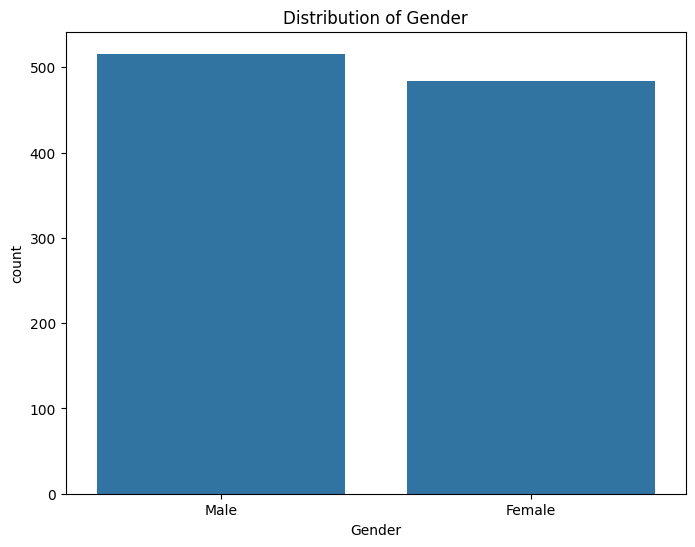

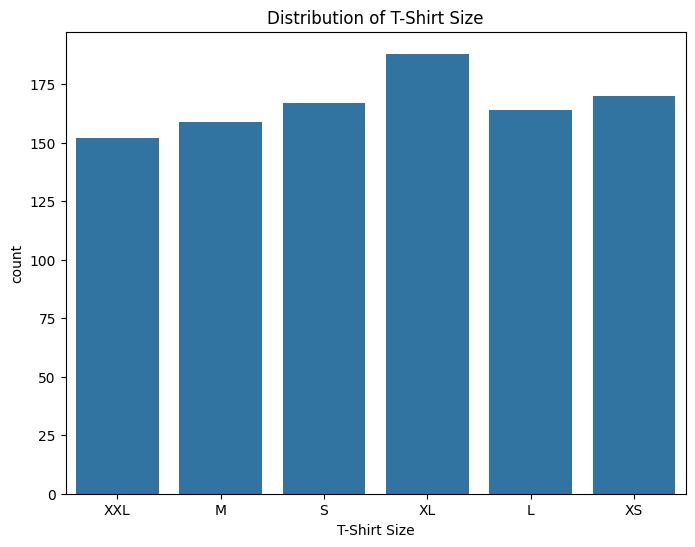

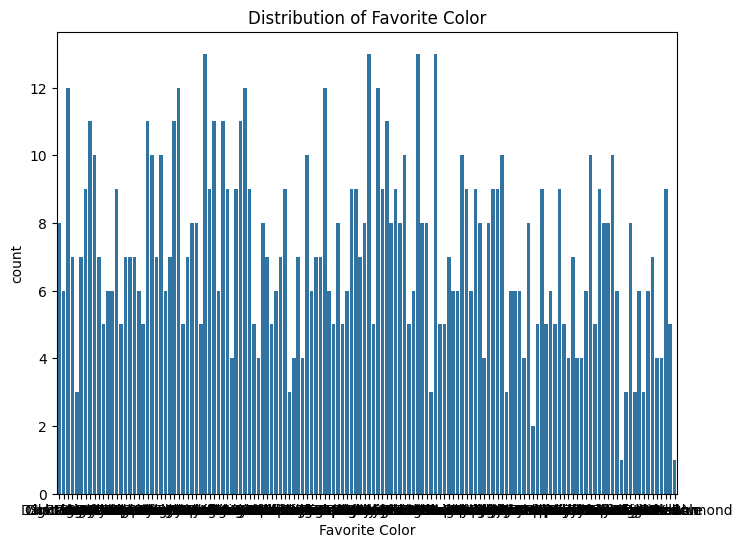

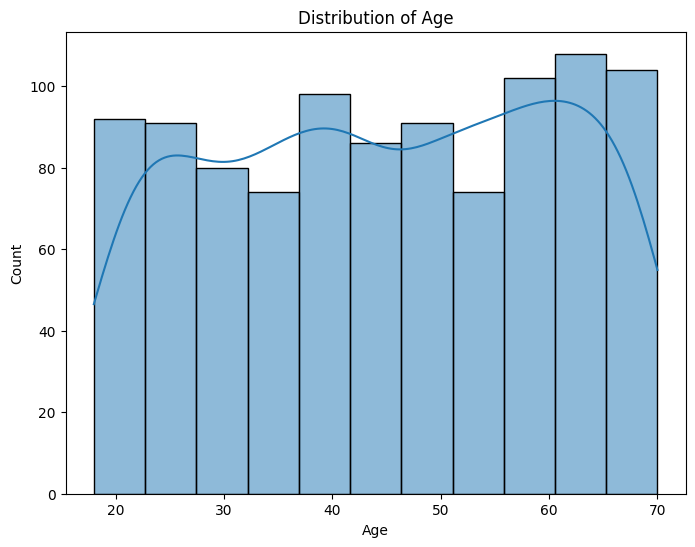

<ipython-input-15-e65587b7890b>:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(customer_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")


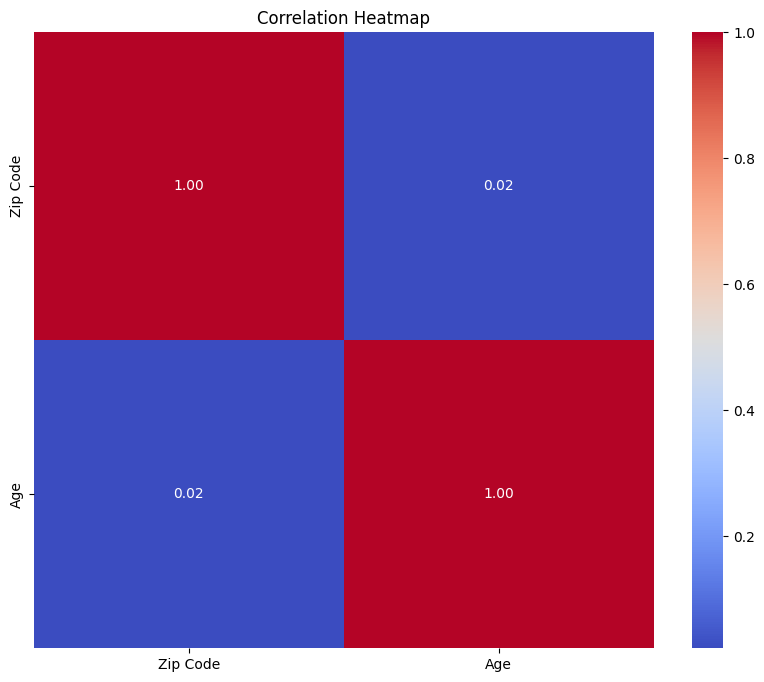

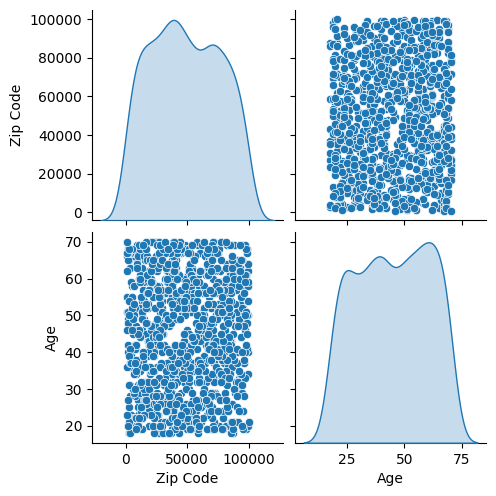

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the T-shirt customer dataset
customer_data = pd.read_csv("customer_data.csv")  # Assuming the dataset file is named "customer_data.csv"

# Basic statistics and data overview
print(customer_data.info())
print(customer_data.describe())

# Distribution of categorical variables
categorical_variables = ['Gender', 'T-Shirt Size', 'Favorite Color']
for var in categorical_variables:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=var, data=customer_data)
    plt.title(f"Distribution of {var}")
    plt.show()

# Distribution of numerical variables
numerical_variables = ['Age']
for var in numerical_variables:
    plt.figure(figsize=(8, 6))
    sns.histplot(customer_data[var], kde=True)
    plt.title(f"Distribution of {var}")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(customer_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Pairplot
sns.pairplot(customer_data, diag_kind='kde')
plt.show()
